## Analiza skategoryzowana
---

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scripts import StockDatabase, UtilsStockPrice
from sklearn.model_selection import train_test_split

### Prepare data

In [49]:
# Read all tickers for WIG_ODZIEZ sector
tickers = pd.read_csv("../database/designData/WIGs.csv")["WIG_ODZIEZ"].dropna()

# Load historical prices 
sdb = StockDatabase()
sdb.load_historical_data(tickers)
common_begin_date = sdb.get_common_begin_date()

# Read &  prepare reports database
report = pd.read_csv("../database/reportData/WIG_ODZIEZ_COMPANY_QQ.csv", index_col=[0])
report["D_DATE"] = report["D_DATE"].astype("datetime64[s]")
report = report[report["D_DATE"] > common_begin_date]

In [50]:
report = pd.read_csv("../database/reportData/Quarterly_Diff.csv", index_col=[0])
report = report.rename(columns={"Date": "D_DATE"})
report["D_DATE"] = report["D_DATE"].astype("datetime64[s]")
report = report[report["D_DATE"] > common_begin_date]
report = report[np.any([report["Ticker"] == t for t in tickers], axis=0)]

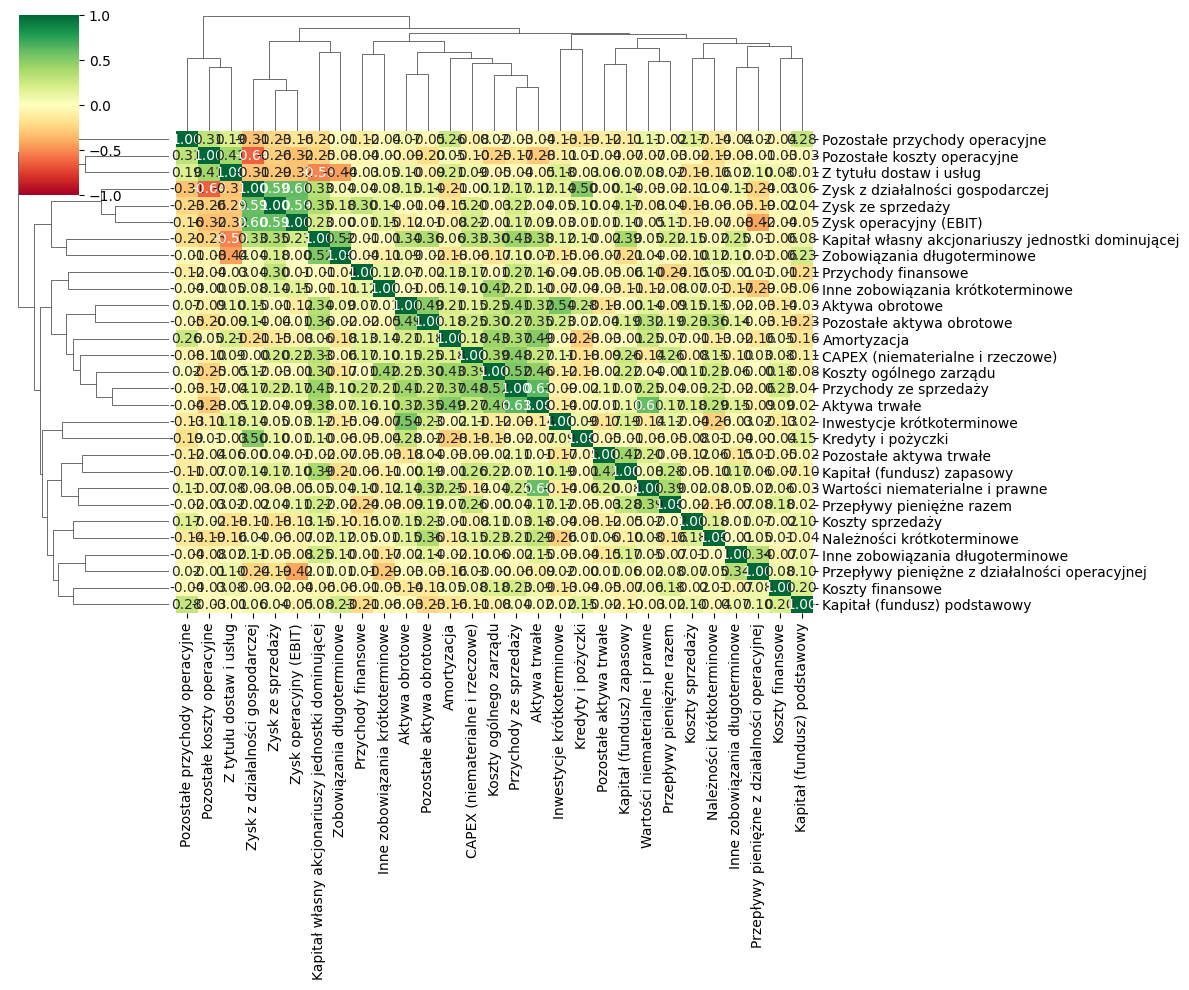

In [51]:
# Remove samples where sum(NaN feature) > 20% all feature (in sample)
report = report.dropna(axis = 0, thresh = report.shape[1] * 0.8)
# Remove feature where sum(NaN feature) > 20% all samples 
report = report.dropna(axis = 1, thresh = report.shape[0] * 0.8)

# Remove correlated feature 
CORRELATION_THRESHOLD = 0.65
corr_matrix = report.drop(columns=["D_DATE", "Ticker"]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > CORRELATION_THRESHOLD)]
report.drop(to_drop, axis=1, inplace=True)

# Display feature correlation
sns.clustermap(report.drop(columns=["D_DATE", "Ticker"]).corr(), 
               cmap='RdYlGn', vmin=-1, vmax=1, fmt='.2f', annot=True, figsize=(12, 10))
plt.show()

In [52]:
# Fill NaN value base on KNNImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
report.iloc[:, 2:] = imputer.fit_transform(report.drop(columns=["D_DATE", "Ticker"]))

In [53]:
# Calculate reference returns (company_return - sector_return)
WINDOW_SIZE = 10
reference_return = []
for _, row in report.iterrows():
    #date, ticker = row[:2]
    ticker, date = row[:2]
    company_return = UtilsStockPrice.average_return(sdb.get_historical_data(ticker), date, window=WINDOW_SIZE)
    sector_return  = UtilsStockPrice.sector_average_return(sdb, date, to_omit=ticker, window=WINDOW_SIZE)
    reference_return.append(company_return - sector_return)

report.insert(0, "ReferenceReturn", reference_return)

In [54]:
# Remove outstanding data (they could be incorrect)
report = report[np.all([report["ReferenceReturn"] < report["ReferenceReturn"].mean() + 3 * report["ReferenceReturn"].std(), 
               report["ReferenceReturn"] > report["ReferenceReturn"].mean() - 3 * report["ReferenceReturn"].std()], axis=0)]

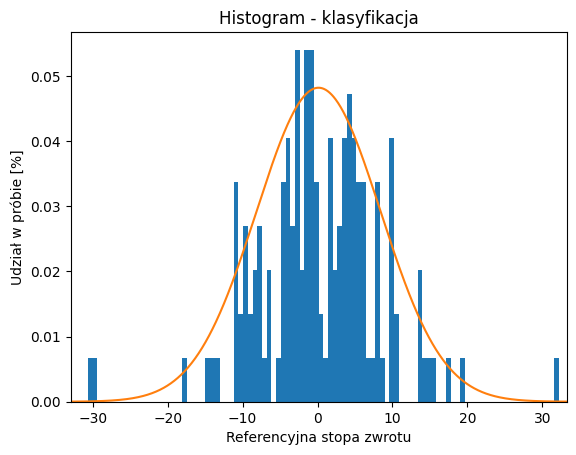

In [55]:
mean = report["ReferenceReturn"].mean()
std  = report["ReferenceReturn"].std() 


x_limits = [mean-4*std, mean+4*std] 
x = np.linspace(*x_limits, 1000)
percent_limits = norm.ppf([0, 0.5, 1], loc=mean, scale=std)

plt.hist(report["ReferenceReturn"], bins=100,  weights=np.ones(len(report["ReferenceReturn"])) / len(report["ReferenceReturn"]))
plt.plot(x, norm.pdf(x, loc=mean, scale=std))
"""
plt.fill_between(np.arange(x_limits[0], percent_limits[1], 1e-2), 
                 norm.pdf(np.arange(x_limits[0], percent_limits[1], 1e-2), loc=mean, scale=std), 
                 alpha = 0.3, color="red")
plt.fill_between(np.arange(percent_limits[1], percent_limits[2], 1e-2), 
                 norm.pdf(np.arange(percent_limits[1], percent_limits[2], 1e-2), loc=mean, scale=std), 
                 alpha = 0.3, color="grey")
plt.fill_between(np.arange(percent_limits[2], x_limits[1], 1e-2), 
                 norm.pdf(np.arange(percent_limits[2], x_limits[1], 1e-2), loc=mean, scale=std), 
                 alpha = 0.3, color="green")
"""
plt.xlim(x_limits)
plt.title("Histogram - klasyfikacja")
plt.ylabel("Udział w próbie [%]")
plt.xlabel("Referencyjna stopa zwrotu")
plt.show()


### Random forest classifier

In [56]:
report["ReferenceReturn"] = pd.cut(report["ReferenceReturn"], bins=percent_limits, labels=[0,1]).to_numpy()

In [57]:
# Import all required classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

TEST_SIZE = [0.3] # Testing `test_size` parameter
N_ITER = 100      # Number of iterations for all tests

# Classifiers
K_NEIGHBORS = [3,5,7]
CLASSIFIERS = [
    LinearDiscriminantAnalysis(), 
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[0]),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[1]),
    KNeighborsClassifier(n_neighbors=K_NEIGHBORS[2]),
    ]

CLASSIFIERS_DOCSTR = [
    "Linear Discriminant Analysis",
    "Quadratic Discriminant Analysis",
    "Random Forest Classifier",
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[0]),
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[1]),
    "KNeighbors Classifier kNN={}".format(K_NEIGHBORS[2]),
]

In [58]:
from sklearn import metrics

def classifier_test(classifier_model, X_train, X_test, y_train, y_test):
    # Uczenie modelu
    classifier_model.fit(X_train, y_train)
    
    # Predykcja
    y_pred = classifier_model.predict(X_test)
    
    # Jakość klasyfikacji
    acc = metrics.accuracy_score(y_test, y_pred)

    # Macierz pomyłek
    cm = metrics.confusion_matrix(y_test, y_pred, labels=classifier_model.classes_, normalize='true')

    return acc, cm

In [59]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.datasets import load_digits
from tqdm import tqdm
import numpy as np

# TODO Check warning
import warnings
warnings.filterwarnings('ignore')

# Read digits data
X = report.iloc[:,3:].to_numpy()
y = report["ReferenceReturn"]
n_classes = 2

# Memory allocation
accuracy_matrix = np.zeros( ( len(TEST_SIZE), len(CLASSIFIERS) ) ) 
confiusion_matrix = np.zeros( ( len(TEST_SIZE), len(CLASSIFIERS), n_classes, n_classes ) ) 

# For each size of `TEST_SIZE`
for i, t_size in enumerate(TEST_SIZE):
    print("{:-^50}".format("Test {}".format(i+1)))
    print("Parameters: test size: {}, n_times: {}".format(t_size, N_ITER))

    # For N iterations
    for k in tqdm(range(N_ITER)):

        # Shuffle and roll test size
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size)

        # For each classifier
        for j, classifier in enumerate(CLASSIFIERS):
            accuracy, confiusion_m = classifier_test(classifier, X_train, X_test, y_train, y_test)
            # Adding evaluation statistics
            accuracy_matrix[i,j] += accuracy
            confiusion_matrix[i,j,:,:] += confiusion_m

# Normalize evaluation statistics
accuracy_matrix /= N_ITER

# Normalize confiusion matrix
for i in range(confiusion_matrix.shape[0]):
    for j in range(confiusion_matrix.shape[1]):
        confiusion_matrix[i,j,:,:] = confiusion_matrix[i,j,:,:] / N_ITER

----------------------Test 1----------------------
Parameters: test size: 0.3, n_times: 100


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


In [64]:
accuracy_matrix[:,:].flatten()

array([0.55777778, 0.57622222, 0.56266667, 0.58888889, 0.54911111,
       0.55222222])

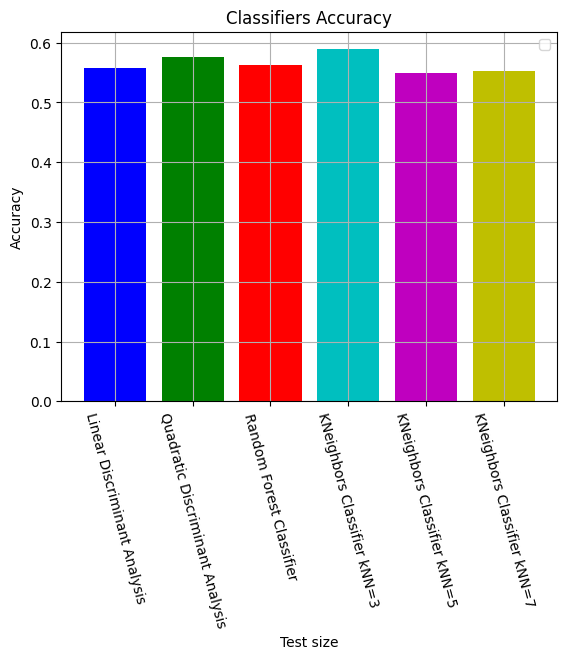

In [79]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

prop_iter = iter(plt.rcParams['axes.prop_cycle'])
plt.bar(CLASSIFIERS_DOCSTR, accuracy_matrix[:,:].flatten(),color=[next(prop_iter)['color'] for _, _ in enumerate(CLASSIFIERS_DOCSTR)])


#plt.ylim([0 , 1])
plt.grid(True)
plt.ylabel("Accuracy")
plt.xlabel("Test size")
plt.xticks(rotation=-75)
plt.title("Classifiers Accuracy")
plt.legend()
plt.rcParams['axes.prop_cycle']= cycler(color='bgrcmyk')
plt.show()


In [74]:
from cycler import cycler
cycler(color='C0V1')

'C'
'0'
'V'
'1'


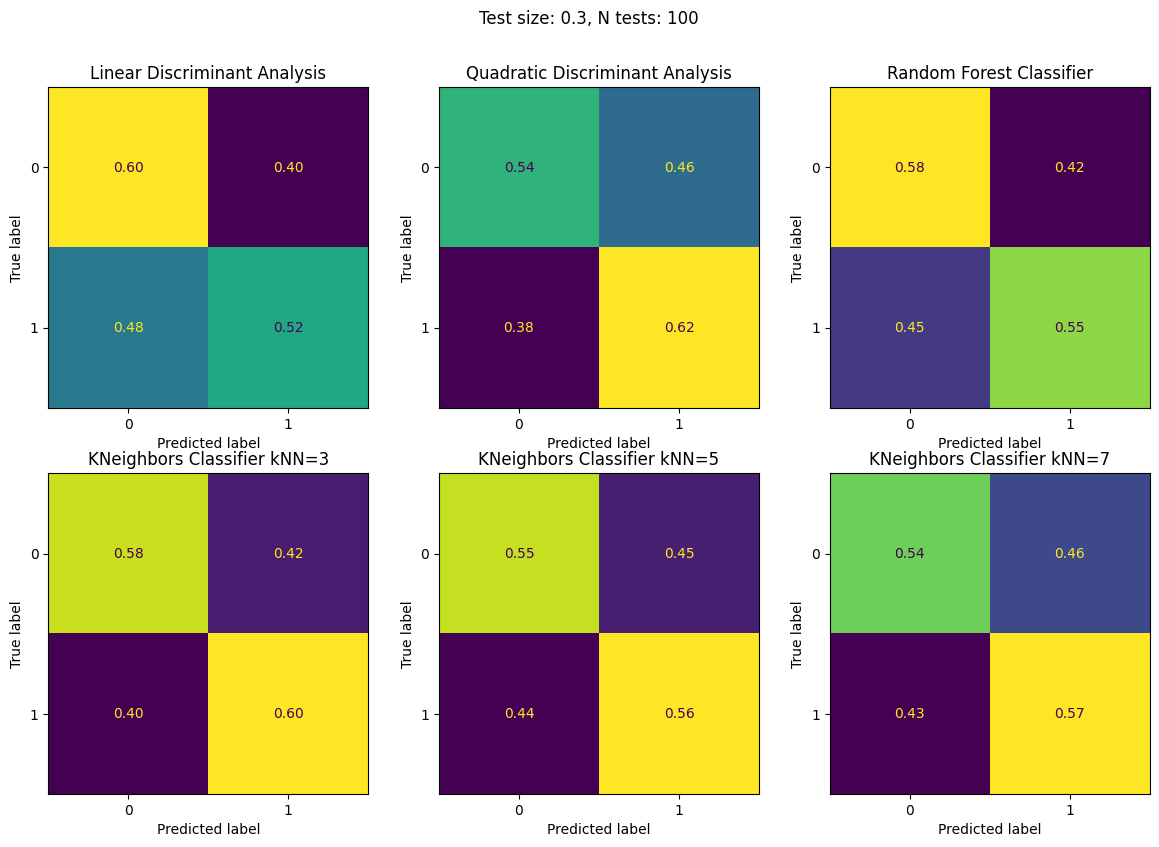

In [61]:
# Import libraries
import matplotlib.pyplot as plt
from sklearn import metrics

# Select display test size variant
#disp_test_size = TEST_SIZE # Default, for display all confusion matrix
disp_test_size = TEST_SIZE

# Plotting parameters
n_plots = len(CLASSIFIERS)
n_cols = 3
n_rows = int(np.ceil(n_plots/n_cols))


# Dla każdego rozmiaru danych testowych
for i, t_size in enumerate(TEST_SIZE):
    if t_size not in disp_test_size:
        continue
    fig, ax = plt.subplots(n_rows,n_cols)
    fig.set_size_inches(4*n_cols, 4*n_rows)
    fig.tight_layout(pad=2)
    fig.suptitle("Test size: {}, N tests: {}".format(t_size, N_ITER), y=1.05)

    # Dla każdego klasyfikatora
    for j, classifier in enumerate(CLASSIFIERS):
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confiusion_matrix[i,j,:,:], display_labels=[0,1])
        disp.plot(ax=ax[j//n_cols, j%n_cols], values_format='.2f')
        ax[j//n_cols, j%n_cols].set_title(CLASSIFIERS_DOCSTR[j])
        disp.im_.colorbar.remove()

    plt.show()